In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv("D:/Python/income_evaluation.csv")

In [4]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

## Data pre-processing

In [5]:
from sklearn.preprocessing import Binarizer

In [6]:
df[' income'] = np.where(df[' income'] == ' >50K', 1, 0)

In [7]:
features = [' workclass', ' education', ' marital-status', ' occupation', ' relationship', ' sex',' race', ' native-country']
df[features] = df[features].apply(LabelEncoder().fit_transform)

In [8]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


## Feature Importance

In [9]:
X = df.drop([' income'], axis = 1)
Y = df[' income']

Feature: 0, Score: 0.11483
Feature: 1, Score: 0.03444
Feature: 2, Score: 0.20584
Feature: 3, Score: 0.01198
Feature: 4, Score: 0.11571
Feature: 5, Score: 0.00601
Feature: 6, Score: 0.05767
Feature: 7, Score: 0.19856
Feature: 8, Score: 0.01278
Feature: 9, Score: 0.00386
Feature: 10, Score: 0.11526
Feature: 11, Score: 0.03744
Feature: 12, Score: 0.07133
Feature: 13, Score: 0.01430


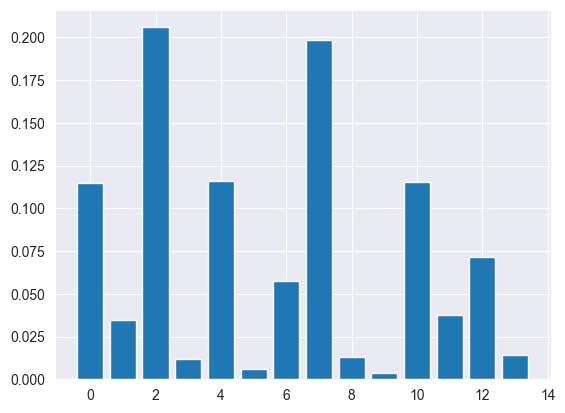

In [10]:
model1 = DecisionTreeClassifier()
model1.fit(X, Y)

# Get importance
importance = model1.feature_importances_

# Summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [11]:
df.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

In [12]:
Counter(Y)

Counter({0: 24720, 1: 7841})

## Under Sampling

In [13]:
rus = RandomUnderSampler(random_state=42)
X_res, Y_res = rus.fit_resample(X, Y)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size = 0.2, random_state = 42)

In [15]:
Counter(Y_res)

Counter({0: 7841, 1: 7841})

In [16]:
sc = StandardScaler(with_mean = False)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## LightGBM

In [17]:
from lightgbm import LGBMClassifier

In [18]:
modelgbm = LGBMClassifier(metric='auc')
# Fit the model on the training data
modelgbm.fit(X_train_scaled, Y_train)

# Make predictions on the training and validation sets
y_train = modelgbm.predict(X_train_scaled)
y_val = modelgbm.predict(X_test_scaled)

[LightGBM] [Info] Number of positive: 6259, number of negative: 6286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 12545, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498924 -> initscore=-0.004305
[LightGBM] [Info] Start training from score -0.004305


In [19]:
from sklearn.metrics import roc_auc_score as ras 

print("Training ROC-AUC: ", ras(Y_train, y_train)) 
print("Validation ROC-AUC: ", ras(Y_test, y_val)) 

Training ROC-AUC:  0.8772177482179401
Validation ROC-AUC:  0.8379565530221422


Accuracy: 0.8380618425247052
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1555
           1       0.83      0.85      0.84      1582

    accuracy                           0.84      3137
   macro avg       0.84      0.84      0.84      3137
weighted avg       0.84      0.84      0.84      3137



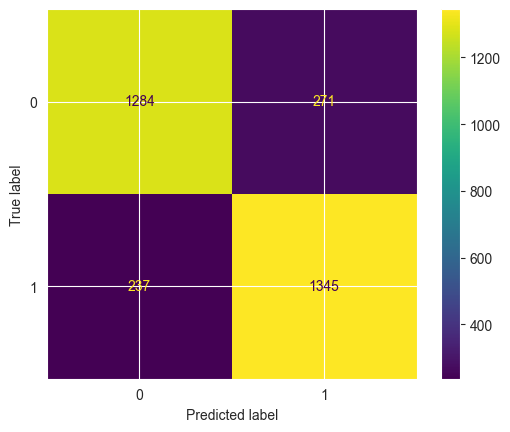

In [20]:
y_pred = modelgbm.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(Y_test, y_pred)
print(f"Classification Report:")
print(report)

conf_m = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=modelgbm.classes_)
disp.plot()
plt.show()

## Classification Visualization via T-SNE

In [22]:
from sklearn.manifold import TSNE

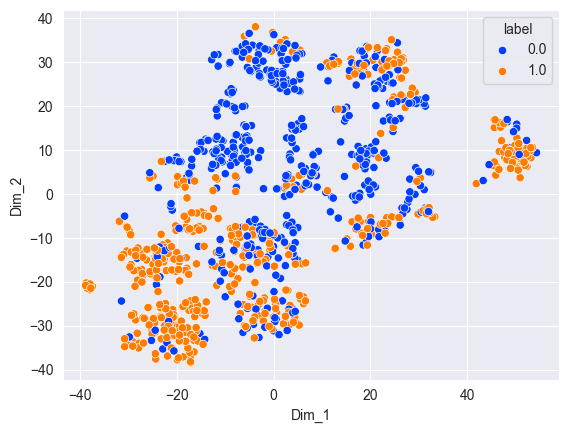

In [23]:
data_1000 = X_train_scaled[0:1000, :]
labels_1000 = Y_train.iloc[0:1000]

# Применение t-SNE
model_tsne = TSNE(n_components=2, random_state=0, init='random')
tsne_data = model_tsne.fit_transform(data_1000)

# Создание нового DataFrame для визуализации
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Визуализация результатов t-SNE
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', hue='label', palette="bright")
plt.show()

In [24]:
def TSNE_plot(model_clf, text):
    model_svm_linear = model_clf
    model_svm_linear.fit(data_1000, labels_1000)

    # Get the model's predictions or transformed features (replace with your features)
    transformed_data = model_svm_linear.predict_proba(data_1000)

    # Configure and fit t-SNE with init="random"
    tsne_model = TSNE(n_components=2, random_state=0, init='random')
    tsne_data = tsne_model.fit_transform(transformed_data)

    # Create a new DataFrame for the result
    tsne_data = np.vstack((tsne_data.T, labels_1000)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Plotting the result of t-SNE
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', hue='label', palette="bright")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(text)
    plt.legend()
    plt.show()

[LightGBM] [Info] Number of positive: 500, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


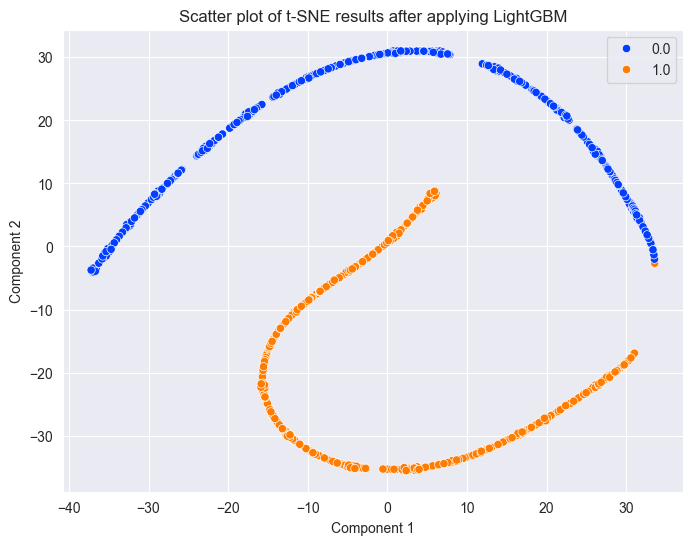

In [25]:
TSNE_plot(modelgbm, "Scatter plot of t-SNE results after applying LightGBM")